# Ames Housing Data - Housing Price Prediction

The entire project is split into three Jupyter notebooks:
1. EDA and data cleaning,
2. Preprocessing and feature engineering,
3. Automated Feature Selection
4. Model tuning and insights

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_style('ticks')

pd.set_option('display.max_columns', None)

%matplotlib inline

# Introduction

The second notebook in the project will cover data preprocessing and feature engineering, based on the findings of EDA in the previous notebook.

## Contents:-

1. Build preprocessing function
2. Check preprocessing function
3. Data transformations
4. Final preprocessing workflow
5. Export preorcessed data

## Build preprocessing function

The following sums up the EDA findings, which will be applied in the functions that follow.

There are 26 columns with null values. Categorical columns with null values will be filled with 'None', and null values in numerical columns will be replaced with 0. For columns with 1-2 null values, the rows containing that value will be dropped.

Some columns are highly skewed towards a single value or had numerous zeros. Among these columns, the following are not likely to be important in terms of saleprice, and will be dropped:
- alley (93.2% null)
- miscval (97% zeros)
- lowqualfinsf (98% zeros)
- street (99.7% single value)
- utilities (99.9% single value)
- condition2 (98.7% single value)
- roofmatl (98.7% single value)
- heating (98.4% single value)
- centralair (93.1% single value)
- electrical (91.1% single value)
- paveddrive (90.7 single value)
- fence (80.5% zeros)
- saletype (86.8% single value)
- bsmthalfbath (94% zeros)
- bsmtfintype2 (85.3% zeros)
- bsmtfinsf2 (88% zeros)
- bsmtcond (89.% single value)
- extercond (86.7% single value)
- garagequal (89.6% single value)

The presence of the following may possibly affect saleprice (e.g. a house has a pool may   be signifiantly more expensive than one without), and will be converted to presence-       absence columns (e.g. 'poolpresence'):
- 3ssnporch (98.7% zeros)
- screenporch (91.2% zeros)
- enclosedporch (84% zeros) (the four different porch columns - 3ssnporch, enclosedporch,     openporch, screenporch - will be combined.)
- poolarea (99.6% zeros)
- poolqc (99.6% single value)

The following columns have large proportions of a single value, but will be kept as is as the minority values may likely affect saleprice.
- functional (93.4% single value)
- garagecond (91.1% single value)
- condition1 (86.2% single value)
- bldgtype (82.9% single value)

The following columns will be added/changed:
- landslope (95.2% single value) - to contain 2 categories, flat and sloped
- exterior materials - exterior2nd will be dropped
- miscfeature (96.8% single value) - to a shed-presence column
- age_sold will be added (difference between year sold and year built)
- garageyrblt will be removed
- mssubclass will be converted to categorical
- remodelled: yes/no (yearremod/add is the same as yearbuilt if there's no remodel)
- garagepres
- fireplacepres
- bsmtpres
- masvnrpres
- 2ndflrpres
- 1stflrsf will be deleted
- 2ndflrsf will be converted to a second floor presence column
- houses with grlivarea bigger than the sum of 1st and 2nd floors will be placed into a new   bighouses column

Outliers will be dropped for those in:
- bsmtfinsf1
- grlivarea
- lotarea
- lotfrontage

And lastly, collinear features will be dropped as well:
- garagecars
- totrmsabvgrd
- totalbsmtsf

## For training data

In [2]:

def preprocess_train(input_df):
    # make copy of df
    df = input_df.copy()
    
    # make columns lowercase and remove spaces
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '')

    # function to drop columns
    def dropcol(df, cols_to_drop):
        df.drop(cols_to_drop, axis = 1, inplace = True)
    
    # --------------------------------------- ADD NEW COLUMNS -------------------------------------------
    
    # 1 if feature present and 0 if feature absent
    pres = lambda x: 1 if x > 0 else 0
    
    # PORCH 
    col_porch = ['3ssnporch','enclosedporch','openporchsf','screenporch']
    df['porchpres'] = df[col_porch].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    dropcol(df, col_porch)
    
    # POOL
    col_pool = ['poolqc','poolarea']
    df['poolpres'] = df['poolarea'].apply(pres)
    dropcol(df, col_pool)
    
    # GARAGE
    df['garagepres'] = df['garagearea'].apply(pres)
    
    # FIREPLACE
    df['fireplacepres'] = df['fireplaces'].apply(pres)
    
    # MASONRY VENEER
    df['masvnrpres'] = df['masvnrarea'].apply(pres)
    
    # BASEMENT
    df['bsmtpres'] = df['bsmtqual'].fillna('none').apply(lambda x: 0 if x == 'none' else 1)

    # LANDSLOPE
    df['landslope'] = df['landslope'].apply(lambda x: 'flat' if x == 'Gtl' else 'sloped')
    
    # MISCFEATURES
    df['shedpres'] = df['miscfeature'].apply(lambda x: 1 if x == 'Shed' else 0)
    dropcol(df, 'miscfeature')
    
    # EXTERIOR MATERIALS
    exterior_materials = {'MetalSd': 'Metal',
                          'HdBoard': 'Wood',
                          'Wd Sdng': 'Wood',
                          'Plywood': 'Wood',
                          'WdShing': 'Wood',
                          'CemntBd': 'Aggregate',
                          'Stucco': 'Aggregate',
                          'CBlock': 'Aggregate',
                          'AsphShn': 'Aggregate',
                          'ImStucc': 'Aggregate',
                          'BrkFace': 'Brick',
                          'BrkComm': 'Brick',
                          'AsbShng': 'Aesbestos',
                          'Stone': 'Stone',
                          'VinylSd': 'Vinyl'}
    df['exterior'] = df['exterior1st'].map(exterior_materials)
    dropcol(df, ['exterior1st','exterior2nd'])

    # AGE SOLD
    for index, val in enumerate(df['yearbuilt']):
        if val == df.loc[index, 'yrsold']:
            df.loc[index, 'age_sold'] = 0
        else:
            df.loc[index, 'age_sold'] = df.loc[index,'yrsold'] - val
    
    # REMODELLED
    for index, val in enumerate(df['yearremod/add']):
        if val == df.loc[index,'yearbuilt']:
            df.loc[index,'remodelled'] = 0
        else:
            df.loc[index,'remodelled'] = 1
    dropcol(df,['yearremod/add'])  
    
    # LIVING AREA
    df['2ndfloorpres'] = df['2ndflrsf'].apply(pres)     
    # get sum of 1stflr and 2ndflr area
    df['flrsf'] = df['1stflrsf']+df['2ndflrsf']
    # create bighouse column
    for index, val in enumerate(df['flrsf']):
        if val == df.loc[index, 'grlivarea']:
            df.loc[index, 'bighouse'] = 0
        else:
            df.loc[index, 'bighouse'] = 1
    dropcol(df, ['flrsf','1stflrsf','2ndflrsf'])
            
    # ---------------------------------------- IMPUTE NULL VALUES ---------------------------------------- 
    
    # LOT FRONTAGE
    # fill nan with neighbourhood median
    median_lotfrt_per_nbhood = df["lotfrontage"].groupby(df["neighborhood"])
    for nbhood, grouped in median_lotfrt_per_nbhood:
        index = (df['neighborhood'] == nbhood) & (df['lotfrontage'].isnull())
        df.loc[index,'lotfrontage'] = grouped.median()
    # for the few remaining rows from the neighborhoods without a median (i.e. if n < 3),
    # fill with overall lotfrontage median
    df['lotfrontage'] = df['lotfrontage'].fillna(df['lotfrontage'].median())

    # MASONRY VENEER
    # the NaN values in masvnrarea and masvnrtype are likely houses without masonry veneers
    df['masvnrarea'] = df['masvnrarea'].fillna(0.0)
    df['masvnrtype'] = df['masvnrtype'].fillna('None')
    
    # BASEMENT PROPERTIES
    # NaN values will be replaced with 'None' (no basement present)
    for col in ['bsmtqual','bsmtexposure','bsmtfintype1']:
        df[col] = df[col].fillna('None')
    # for the NaNs in the numerical columns, they will be replaced with 0 (since no basement)
    for col in ['bsmtfullbath','bsmtfinsf1','bsmtunfsf']:
        df[col] = df[col].fillna(0.0)

    # FIREPLACE
    # null value likely represent no fireplace
    df['fireplacequ'] = df['fireplacequ'].fillna('None')
    
    # GARAGE
    # null values likely represent no garage
    for col in ['garagetype','garagefinish','garagecond']:
        df[col] = df[col].fillna('NA')
    for col in ['garagearea','garagecars','garagearea']:
        df[col] = df[col].fillna(0.0)

    # ------------------------------ CONVERT ORDINAL CATEGORIES TO NUMERICAL ------------------------------
    
    # function to map new values
    def map_new_vals(colname,dictionary):
        df[colname] = df[colname].map(dictionary)
    
    # defining dictionaries for renaming
    lotshape_di = {'Reg': 0,
                   'IR1': 1,
                   'IR2': 2,
                   'IR3': 3}
    bsmtex_di = {'None': 0,
                'No': 1,
                'Mn': 2,
                'Av': 3,
                'Gd': 4}
    qual_di = {'Ex': 5,
               'Gd': 4,
               'TA': 3,
               'Fa': 2,
               'Po': 1,
               'None': 0}
    
    # map new values
    map_new_vals('lotshape', dictionary = lotshape_di)
    map_new_vals('bsmtexposure', dictionary = bsmtex_di)
    map_new_vals('exterqual', dictionary = qual_di)
    map_new_vals('bsmtqual', dictionary = qual_di)
    map_new_vals('heatingqc', dictionary = qual_di)
    map_new_vals('kitchenqual', dictionary = qual_di)
    map_new_vals('fireplacequ', dictionary = qual_di)

    # --------------------------------- CONVERT NUMERICAL TO CATEGORICAL --------------------------------
    
    df['mssubclass'] = df['mssubclass'].astype(str)

    # ------------------------------------------ DROP COLUMNS -------------------------------------------
        
    # SKEWED COLUMNS
    # columns with >80% single category or >80% zeros, plus pid columns
    col_to_drop = ['alley','miscval','lowqualfinsf','street','utilities','condition2','roofmatl',\
                   'heating','centralair','electrical','paveddrive','fence','saletype','bsmthalfbath',\
                   'bsmtfintype2','bsmtfinsf2','bsmtcond','extercond','garagequal']
    dropcol(df, col_to_drop)
    
    # PID COLUMN
    dropcol(df, ['pid'])

    # COLLINEAR COLUMNS
    col_collinear = ['garagecars','totrmsabvgrd', 'totalbsmtsf','garageyrblt']
    dropcol(df, col_collinear) 

    # --------------------------------------- REMOVE OUTLIERS -----------------------------------------
    
    df.drop(df[df['grlivarea'] > 4_500].index, inplace = True)
    df.drop(df[df['lotfrontage'] > 300].index, inplace = True)
    df.drop(df[df['lotarea'] > 100_000].index, inplace = True)

    # ----------------------------------------- CLEANING UP -------------------------------------------
    
    # convert all NA to None
    df.replace('NA','None',inplace=True)

    # reset index
    df = df.reset_index()

    return df

## For test data

This is the same as the function for training data, except without dropping outliers in order to preserve the total number of rows (required for Kaggle submission).

In [3]:
def preprocess_test(input_df):
    # make copy of df
    df = input_df.copy()
    
    # make columns lowercase and remove spaces
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ', '')

    # function to drop columns
    def dropcol(df, cols_to_drop):
        df.drop(cols_to_drop, axis = 1, inplace = True)
    
    # --------------------------------------- ADD NEW COLUMNS -------------------------------------------
    
    # 1 if feature present and 0 if feature absent
    pres = lambda x: 1 if x > 0 else 0
    
    # PORCH 
    col_porch = ['3ssnporch','enclosedporch','openporchsf','screenporch']
    df['porchpres'] = df[col_porch].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    dropcol(df, col_porch)
    
    # POOL
    col_pool = ['poolqc','poolarea']
    df['poolpres'] = df['poolarea'].apply(pres)
    dropcol(df, col_pool)
    
    # GARAGE
    df['garagepres'] = df['garagearea'].apply(pres)
    
    # FIREPLACE
    df['fireplacepres'] = df['fireplaces'].apply(pres)
    
    # MASONRY VENEER
    df['masvnrpres'] = df['masvnrarea'].apply(pres)
    
    # BASEMENT
    df['bsmtpres'] = df['bsmtqual'].fillna('none').apply(lambda x: 0 if x == 'none' else 1)

    # LANDSLOPE
    df['landslope'] = df['landslope'].apply(lambda x: 'flat' if x == 'Gtl' else 'sloped')
    
    # MISCFEATURES
    df['shedpres'] = df['miscfeature'].apply(lambda x: 1 if x == 'Shed' else 0)
    dropcol(df, 'miscfeature')
    
    # EXTERIOR MATERIALS
    exterior_materials = {'MetalSd': 'Metal',
                          'HdBoard': 'Wood',
                          'Wd Sdng': 'Wood',
                          'Plywood': 'Wood',
                          'WdShing': 'Wood',
                          'CemntBd': 'Aggregate',
                          'Stucco': 'Aggregate',
                          'CBlock': 'Aggregate',
                          'AsphShn': 'Aggregate',
                          'ImStucc': 'Aggregate',
                          'BrkFace': 'Brick',
                          'BrkComm': 'Brick',
                          'AsbShng': 'Aesbestos',
                          'Stone': 'Stone',
                          'VinylSd': 'Vinyl'}
    df['exterior'] = df['exterior1st'].map(exterior_materials)
    dropcol(df, ['exterior1st','exterior2nd'])

    # AGE SOLD
    for index, val in enumerate(df['yearbuilt']):
        if val == df.loc[index, 'yrsold']:
            df.loc[index, 'age_sold'] = 0
        else:
            df.loc[index, 'age_sold'] = df.loc[index,'yrsold'] - val
    
    # REMODELLED
    for index, val in enumerate(df['yearremod/add']):
        if val == df.loc[index,'yearbuilt']:
            df.loc[index,'remodelled'] = 0
        else:
            df.loc[index,'remodelled'] = 1
    dropcol(df,['yearremod/add'])  
    
    # LIVING AREA
    df['2ndfloorpres'] = df['2ndflrsf'].apply(pres)     
    # get sum of 1stflr and 2ndflr area
    df['flrsf'] = df['1stflrsf']+df['2ndflrsf']
    # create bighouse column
    for index, val in enumerate(df['flrsf']):
        if val == df.loc[index, 'grlivarea']:
            df.loc[index, 'bighouse'] = 0
        else:
            df.loc[index, 'bighouse'] = 1
    dropcol(df, ['flrsf','1stflrsf','2ndflrsf'])
            
    # ---------------------------------------- IMPUTE NULL VALUES ---------------------------------------- 
    
    # LOT FRONTAGE
    # fill nan with neighbourhood median
    median_lotfrt_per_nbhood = df["lotfrontage"].groupby(df["neighborhood"])
    for nbhood, grouped in median_lotfrt_per_nbhood:
        index = (df['neighborhood'] == nbhood) & (df['lotfrontage'].isnull())
        df.loc[index,'lotfrontage'] = grouped.median()
    # for the few remaining rows from the neighborhoods without a median (i.e. if n < 3),
    # fill with overall lotfrontage median
    df['lotfrontage'] = df['lotfrontage'].fillna(df['lotfrontage'].median())

    # MASONRY VENEER
    # the NaN values in masvnrarea and masvnrtype are likely houses without masonry veneers
    df['masvnrarea'] = df['masvnrarea'].fillna(0.0)
    df['masvnrtype'] = df['masvnrtype'].fillna('None')
    
    # BASEMENT PROPERTIES
    # NaN values will be replaced with 'None' (no basement present)
    for col in ['bsmtqual','bsmtexposure','bsmtfintype1']:
        df[col] = df[col].fillna('None')
    # for the NaNs in the numerical columns, they will be replaced with 0 (since no basement)
    for col in ['bsmtfullbath','bsmtfinsf1','bsmtunfsf']:
        df[col] = df[col].fillna(0.0)

    # FIREPLACE
    # null value likely represent no fireplace
    df['fireplacequ'] = df['fireplacequ'].fillna('None')
    
    # GARAGE
    # null values likely represent no garage
    for col in ['garagetype','garagefinish','garagecond']:
        df[col] = df[col].fillna('NA')
    for col in ['garagearea','garagecars','garagearea']:
        df[col] = df[col].fillna(0.0)

    # ------------------------------ CONVERT ORDINAL CATEGORIES TO NUMERICAL ------------------------------
    
    # function to map new values
    def map_new_vals(colname,dictionary):
        df[colname] = df[colname].map(dictionary)
    
    # defining dictionaries for renaming
    lotshape_di = {'Reg': 0,
                   'IR1': 1,
                   'IR2': 2,
                   'IR3': 3}
    bsmtex_di = {'None': 0,
                'No': 1,
                'Mn': 2,
                'Av': 3,
                'Gd': 4}
    qual_di = {'Ex': 5,
               'Gd': 4,
               'TA': 3,
               'Fa': 2,
               'Po': 1,
               'None': 0}
    
    # map new values
    map_new_vals('lotshape', dictionary = lotshape_di)
    map_new_vals('bsmtexposure', dictionary = bsmtex_di)
    map_new_vals('exterqual', dictionary = qual_di)
    map_new_vals('bsmtqual', dictionary = qual_di)
    map_new_vals('heatingqc', dictionary = qual_di)
    map_new_vals('kitchenqual', dictionary = qual_di)
    map_new_vals('fireplacequ', dictionary = qual_di)

    # --------------------------------- CONVERT NUMERICAL TO CATEGORICAL --------------------------------
    
    df['mssubclass'] = df['mssubclass'].astype(str)

    # ------------------------------------------ DROP COLUMNS -------------------------------------------
        
    # SKEWED COLUMNS
    # columns with >80% single category or >80% zeros, plus pid columns
    col_to_drop = ['alley','miscval','lowqualfinsf','street','utilities','condition2','roofmatl',\
                   'heating','centralair','electrical','paveddrive','fence','saletype','bsmthalfbath',\
                   'bsmtfintype2','bsmtfinsf2','bsmtcond','extercond','garagequal']
    dropcol(df, col_to_drop)
    
    # PID COLUMN
    dropcol(df, ['pid'])

    # COLLINEAR COLUMNS
    col_collinear = ['garagecars','totrmsabvgrd', 'totalbsmtsf','garageyrblt']
    dropcol(df, col_collinear) 

    # --------------------------------------- REMOVE OUTLIERS -----------------------------------------
    
#     df.drop(df[df['grlivarea'] > 4_500].index, inplace = True)
#     df.drop(df[df['lotfrontage'] > 300].index, inplace = True)
#     df.drop(df[df['lotarea'] > 100_000].index, inplace = True)

    # ----------------------------------------- CLEANING UP -------------------------------------------
    
    # convert all NA to None
    df.replace('NA','None',inplace=True)

    # reset index
    df = df.reset_index()

    return df

## Check preprocessing function

In [4]:
# scatterplot subplots
def subplot_scatter(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/4)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=4,figsize=(15, nrows*3.5)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        sns.regplot(y=dataframe.saleprice, x=dataframe[column],ax=ax[i], \
                    scatter_kws={'facecolors':'skyblue','edgecolor':'skyblue'},
                    line_kws = {'color':'grey'})
        ax[i].set_title(f'{column} vs saleprice',fontsize=14)  
        ax[i].tick_params(labelsize=12)
        ax[i].set_xlabel(column, fontsize=14)
        ax[i].set_ylabel('saleprice', fontsize=14)
    plt.tight_layout()

# histogram subplots
def subplot_histograms(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/4)) 
    fig, ax = plt.subplots(nrows=nrows, ncols=4,figsize=(15, nrows*3.5)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        ax[i].hist(dataframe[column],bins=15)
        ax[i].set_title(f'{column} distribution',fontsize=14)
        ax[i].tick_params(labelsize=12)
        ax[i].set_xlabel(column, fontsize=14)
    plt.tight_layout()
    
# distribution plots (histogram, boxplot, probplot)
def dist_plots(df, list_of_columns):
    nrows = len(list_of_columns)
    fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize=(15, nrows*3.5))
    ax = ax.ravel()
    for i, col in enumerate(list_of_columns):
        sns.distplot(df[col], ax = ax[i*3-3])
        ax[i*3-3].set_title(f'{col} distribution plot',fontsize=14)
        ax[i*3-3].tick_params(labelsize=12)
        ax[i*3-3].set_xlabel(col, fontsize=14)
        
        sns.boxplot(df[col], width = 0.2, ax = ax[i*3-2])
        ax[i*3-2].set_title(f'{col} box plot',fontsize=14)
        ax[i*3-2].tick_params(labelsize=12)
        ax[i*3-2].set_xlabel(col, fontsize=14)
        
        stats.probplot(df[col], plot = ax[i*3-1])
        ax[i*3-1].set_title(f'{col} probability plot', fontsize=14)
        ax[i*3-1].tick_params(labelsize=12)
        ax[i*3-1].set_xlabel(col, fontsize=14)
    plt.tight_layout()

In [5]:
# import train
train = pd.read_csv ("datasets/train.csv")

# run preprocessing function
train_preprocessed = preprocess_train(train)

# check df
print(train_preprocessed.columns)
train_preprocessed.info()

# no null values
# on the training data, the preprocessing function retains 2042 out of 2051 samples (99.5%) 

Index(['index', 'id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea',
       'lotshape', 'landcontour', 'lotconfig', 'landslope', 'neighborhood',
       'condition1', 'bldgtype', 'housestyle', 'overallqual', 'overallcond',
       'yearbuilt', 'roofstyle', 'masvnrtype', 'masvnrarea', 'exterqual',
       'foundation', 'bsmtqual', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtunfsf', 'heatingqc', 'grlivarea', 'bsmtfullbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual', 'functional',
       'fireplaces', 'fireplacequ', 'garagetype', 'garagefinish', 'garagearea',
       'garagecond', 'wooddecksf', 'mosold', 'yrsold', 'saleprice',
       'porchpres', 'poolpres', 'garagepres', 'fireplacepres', 'masvnrpres',
       'bsmtpres', 'shedpres', 'exterior', 'age_sold', 'remodelled',
       '2ndfloorpres', 'bighouse'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2046 entries, 0 to 2045
Data columns (total 58 columns):
 #   Co

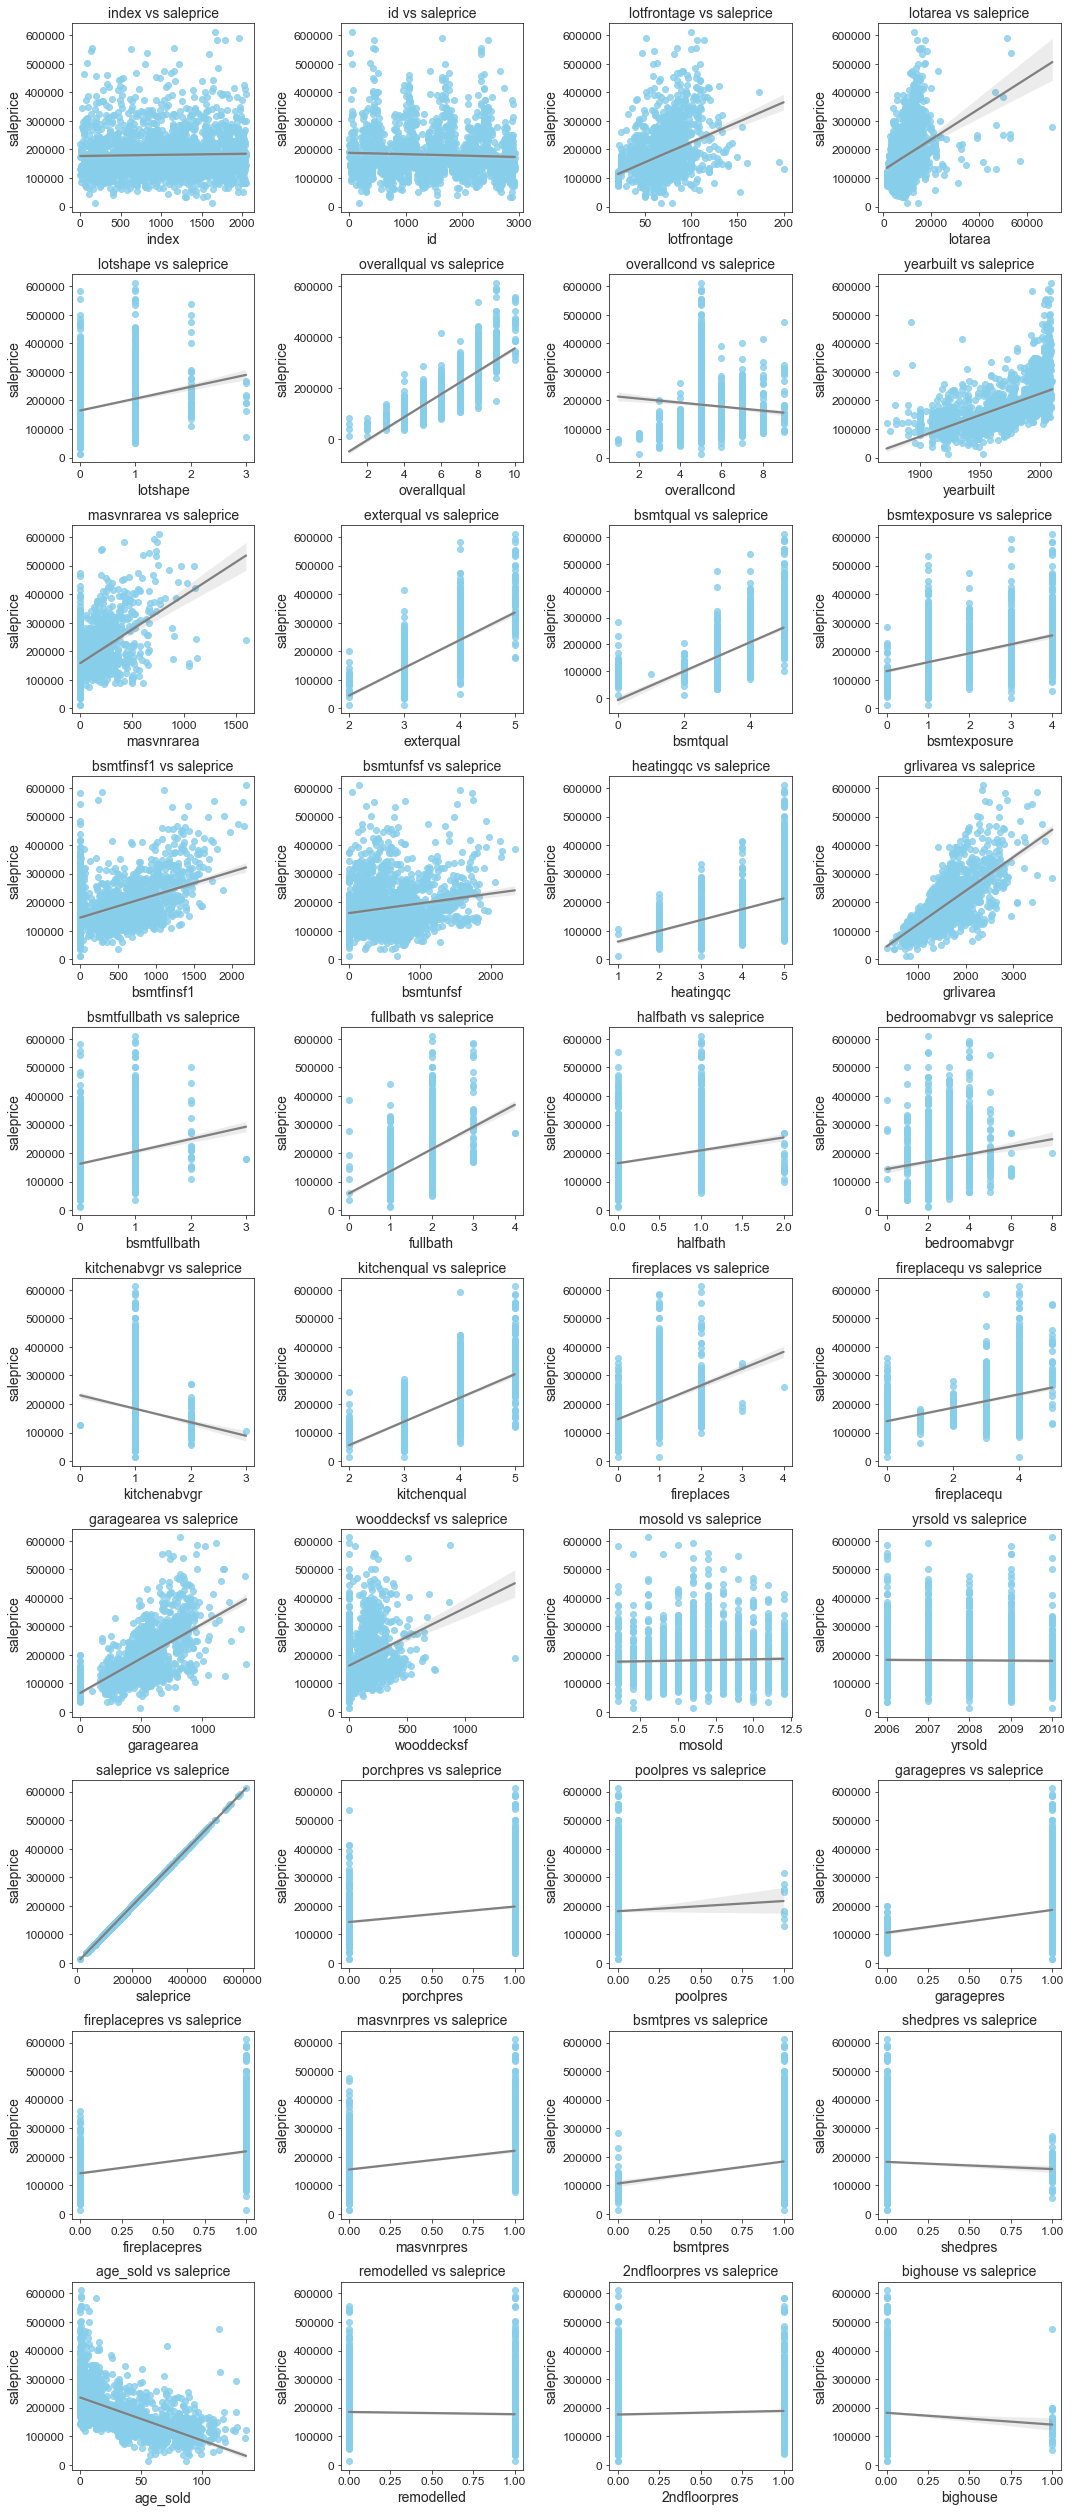

In [6]:
# check scatterplots 
col_numerical = [col for col in train_preprocessed.columns if train_preprocessed[col].dtype != np.object]
subplot_scatter(train_preprocessed,col_numerical)

# no outliers

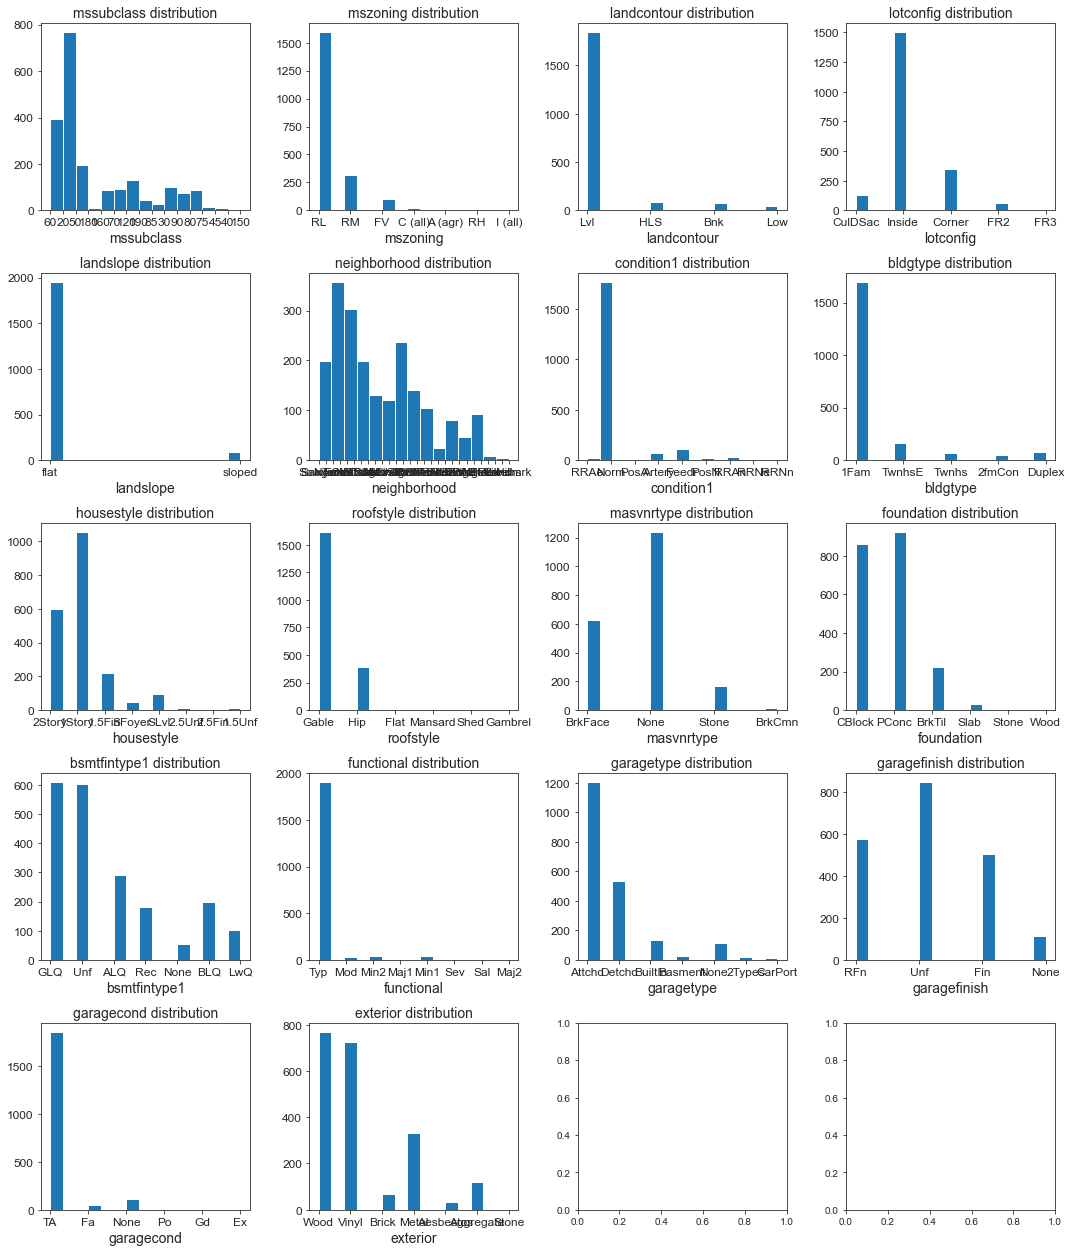

In [7]:
# check histograms
col_categorical = [col for col in train_preprocessed.columns if col not in col_numerical]
subplot_histograms(train_preprocessed,col_categorical)


## Transformations

## Skewness

The skewness scores below represent the Fisher-Pearson coefficient, which measures of how skewed the data is. Values > 0 means the data is right skewed, and values < 0 means the data is left skewed. Normally distributed data has a skewness of 0.

The graph below compares the results of the log, BoxCox, and square transformation with the skewness of the original data. As expected, the log and Box-Cox transformations made the right skewed features less skewed, but made the left skewed features worse. The opposite was true for square transformation.

For positively skewed features, log transformation will be used as it seemed to have performed slightly better than Box-Cox. For negatively skewed features, the square transformation will be used. The following features will not be transformed as transformation made their skewness score worse:

bsmtunfsf
age_sold
lotfrontage
bedroomsabvgr
mosold
However, model testing (notebook #3 in this project) showed that despite these findings, a Box-Cox transformation on all skewed features performed the best.

In [8]:
from scipy.stats import skew

# one zero columns
col_onezero = [col for col in train_preprocessed.columns if len(train_preprocessed[col].unique()) == 2]

# measure skewness of numerical columns (without one zero columns)
col_numerical = [col for col in train_preprocessed.columns if train_preprocessed[col].dtype != np.object]
col_numerical = [col for col in col_numerical if col not in col_onezero]

skewed = train_preprocessed[col_numerical].apply(lambda x: skew(x.astype(float)))

# obtain features with skewness > 0.2
skewed = skewed[abs(skewed) > 0.2]
skewed_df = pd.DataFrame({'skewness_score_original':skewed})

## Log transformation


In [9]:
test = train_preprocessed.copy()
skewed_col = skewed.index

# log1p transform (log(1+x))
for col in skewed_col:
    test[col] = np.log1p(test[col])

# result of log transformation
results = test[skewed_col].apply(lambda x: skew(x.astype(float)))
skewed_df['log_transformed'] = results

## Box cox power transformation

In [10]:
test = train_preprocessed.copy()

# box cox power transformation
from scipy.special import boxcox1p

for col in skewed_col:
    test[col] = boxcox1p(test[col],0.15)

# results of boxcox transformation
results = test[skewed_col].apply(lambda x: skew(x.astype(float)))
skewed_df['boxcox_transformed'] = results


## Square transformation


In [11]:
test = train_preprocessed.copy()

for col in skewed_col:
    test[col] = np.square(test[col])

# results of square transformation
results = test[skewed_col].apply(lambda x: skew(x.astype(float)))
skewed_df['squared'] = results

## Result of transformations

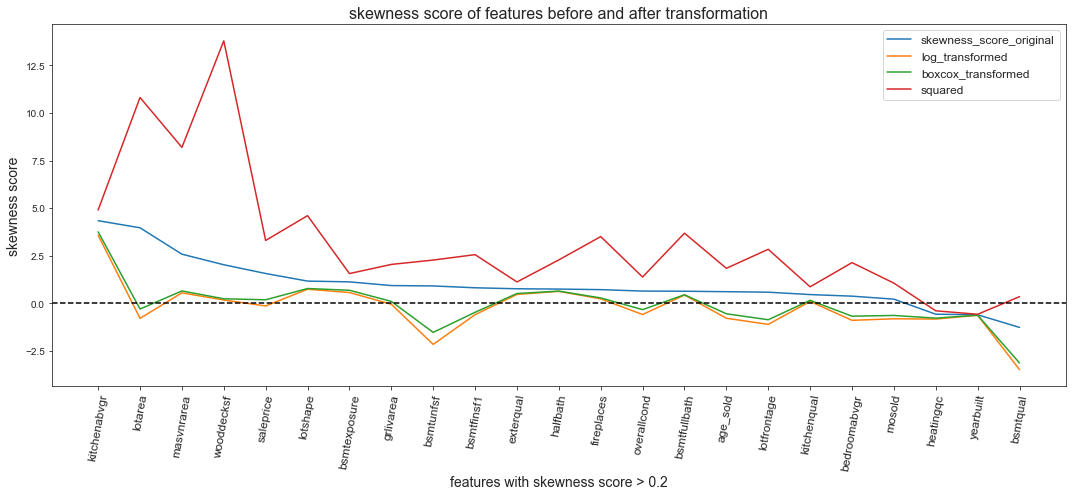

In [12]:
# plot skewness score
skewed_df = skewed_df.sort_values(by ='skewness_score_original', ascending=False)
skewed_df.plot(figsize=(15,7))
plt.axhline(0, linestyle='--', color='k')
plt.xticks(np.arange(len(skewed_df)), skewed_df.index.values, rotation = 80, fontsize=12)
plt.xlabel('features with skewness score > 0.2', fontsize=14)
plt.ylabel('skewness score', fontsize=14)
plt.title('skewness score of features before and after transformation', fontsize=16)
plt.legend(loc = 'upper right',  prop={'size': 12})
plt.tight_layout()

## Final preprocessing workflow

Two methods for transformation were tested - one with log and square transformations and one with Box-Cox transformation.

In [13]:
# METHOD ONE - BOX-COX

# import data
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')

# preprocessing
train_preprocessed = preprocess_train(train)
test_preprocessed = preprocess_test(test)

# transformation
skewed_col = [col for col in skewed_col if col != 'saleprice']
for col in skewed_col:
    train_preprocessed[col] = boxcox1p(train_preprocessed[col],0.15)
    test_preprocessed[col] = boxcox1p(test_preprocessed[col],0.15)

train_preprocessed['saleprice'] = boxcox1p(train_preprocessed['saleprice'],0.15)

In [14]:
# METHOD TWO - LOG/SQUARE

# import data
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')

# preprocessing
train_preprocessed = preprocess_train(train)
test_preprocessed = preprocess_test(test)

# transformation
log_transform = ['kitchenabvgr','lotarea','masvnrarea','wooddecksf','mssubclass','lotshape',\
             'bsmtexposure','grlivarea','bsmtfinsf1','exterqual','halfbath','fireplaces',\
             'overallcond','bsmtfullbath','kitchenqual'] 
sq_transform = ['heatingqc','yearbuilt','bsmtqual']

for col in log_transform:
    train_preprocessed[col] = train_preprocessed[col].astype(float)
    train_preprocessed[col] = np.log1p(train_preprocessed[col])
    test_preprocessed[col] = test_preprocessed[col].astype(float)
    test_preprocessed[col] = np.log1p(test_preprocessed[col])
for col in sq_transform:
    train_preprocessed[col] = np.square(train_preprocessed[col])
    test_preprocessed[col] = np.square(test_preprocessed[col])
    
train_preprocessed['saleprice'] = np.log1p(train_preprocessed['saleprice'])

# Export data

The cleaned and preprocessed data are exported and will be used in the next notebook (3 - Model Tuning and Insights) in this project.

In [15]:
train_preprocessed.to_csv('datasets/train_cleaned.csv')
test_preprocessed.to_csv('datasets/test_cleaned.csv')